In [55]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display

from DLHelperFunctions import *

import librosa.display
import librosa
import soundfile as sf

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [56]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [57]:
# Set the dataset path
OPUS_DATASET_PATH = './data/mswc_microset/'
WAV_DATASET_PATH = './data/mswc_microset_wav/'
TRIMD_DATASET_PATH = './data/mswc_microset_trimd/'

# Download the dataset
opus_dir = pathlib.Path(OPUS_DATASET_PATH)
wav_dir = pathlib.Path(WAV_DATASET_PATH)
trimd_dir = pathlib.Path(TRIMD_DATASET_PATH)
if not opus_dir.exists():
    tf.keras.utils.get_file(
        'mswc_microset.tar.gz',
        origin="https://storage.googleapis.com/public-datasets-mswc/mswc_microset.tar.gz",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [58]:
# Convert OPUS to WAV & Reformat the directories
wav_ds = os.path.join(wav_dir, 'clips/')

if not os.path.exists(wav_dir):
    os.makedirs(wav_dir)
    if not os.path.exists(wav_ds):
        os.makedirs(wav_ds)

    en_opus_path = os.path.join(opus_dir, 'en/clips/')
    es_opus_path = os.path.join(opus_dir, 'es/clips/')

    opus_to_wav(en_opus_path, wav_ds)
    opus_to_wav(es_opus_path, wav_ds)

In [59]:
# Trim Audio of silence and store
trmd_ds = os.path.join(trimd_dir, 'clips/')

if not os.path.exists(trimd_dir):
    os.makedirs(trimd_dir)
    if not os.path.exists(trmd_ds):
        os.makedirs(trmd_ds)

    for word in os.listdir(wav_ds):
        wav_word_path = os.path.join(wav_ds, word)
        print("Trimming WAVs of \"" + word + "\" class")
        print('++++++++++++++++++++++++++++++++++')
        new_wav_word_path = os.path.join(trmd_ds, word)
        os.makedirs(new_wav_word_path)
        for wav in os.listdir(wav_word_path):
            cur_wav = os.path.join(wav_word_path, wav)
            new_cur_wav = os.path.join(new_wav_word_path, "t_" + wav)
            t_wav, sr = trim_audio(cur_wav)
            #open(os.path.join(trmd_ds, t_name), 'a').close()
            sf.write(new_cur_wav, t_wav, sr, format='wav')
    print('DONE!')

In [60]:
# Print the Classification Commands of the Dataset
words = np.array(tf.io.gfile.listdir(wav_ds))
words = np.sort(words)
print('Words:', words)

Words: ['en-backward' 'en-bed' 'en-bird' 'en-down' 'en-eight' 'en-five'
 'en-follow' 'en-forward' 'en-four' 'en-house' 'en-learn' 'en-left'
 'en-marvin' 'en-nine' 'en-off' 'en-one' 'en-right' 'en-seven' 'en-sheila'
 'en-six' 'en-stop' 'en-three' 'en-tree' 'en-two' 'en-visual' 'en-wow'
 'en-yes' 'en-zero' 'es-canción' 'es-cero' 'es-cinco' 'es-ciudad'
 'es-color' 'es-cuatro' 'es-dos' 'es-encuentra' 'es-juego' 'es-nombre'
 'es-nueve' 'es-número' 'es-ocho' 'es-seis' 'es-siete' 'es-tiempo'
 'es-tres' 'es-universidad' 'es-uno' 'es-vida']


In [61]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    #directory=wav_ds,
    directory=trmd_ds,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=20000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 116215 files belonging to 48 classes.
Using 92972 files for training.
Using 23243 files for validation.

label names: ['en-backward' 'en-bed' 'en-bird' 'en-down' 'en-eight' 'en-five'
 'en-follow' 'en-forward' 'en-four' 'en-house' 'en-learn' 'en-left'
 'en-marvin' 'en-nine' 'en-off' 'en-one' 'en-right' 'en-seven' 'en-sheila'
 'en-six' 'en-stop' 'en-three' 'en-tree' 'en-two' 'en-visual' 'en-wow'
 'en-yes' 'en-zero' 'es-canción' 'es-cero' 'es-cinco' 'es-ciudad'
 'es-color' 'es-cuatro' 'es-dos' 'es-encuentra' 'es-juego' 'es-nombre'
 'es-nueve' 'es-número' 'es-ocho' 'es-seis' 'es-siete' 'es-tiempo'
 'es-tres' 'es-universidad' 'es-uno' 'es-vida']


In [62]:
train_ds.element_spec

(TensorSpec(shape=(None, 20000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [63]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [64]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [65]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 20000)
(64,)


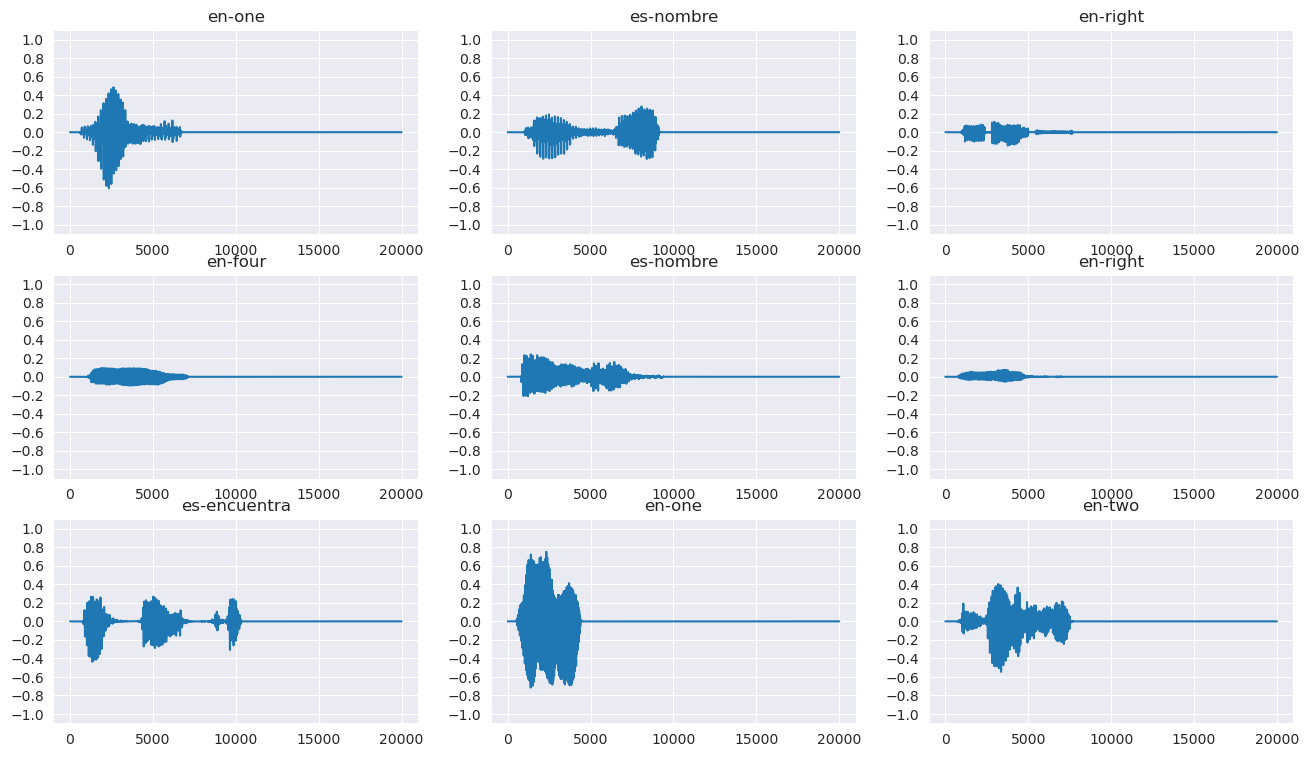

In [66]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [67]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=20000))

Label: en-one
Waveform shape: (20000,)
Spectrogram shape: (155, 129, 1)
Audio playback


Label: es-nombre
Waveform shape: (20000,)
Spectrogram shape: (155, 129, 1)
Audio playback


Label: en-right
Waveform shape: (20000,)
Spectrogram shape: (155, 129, 1)
Audio playback


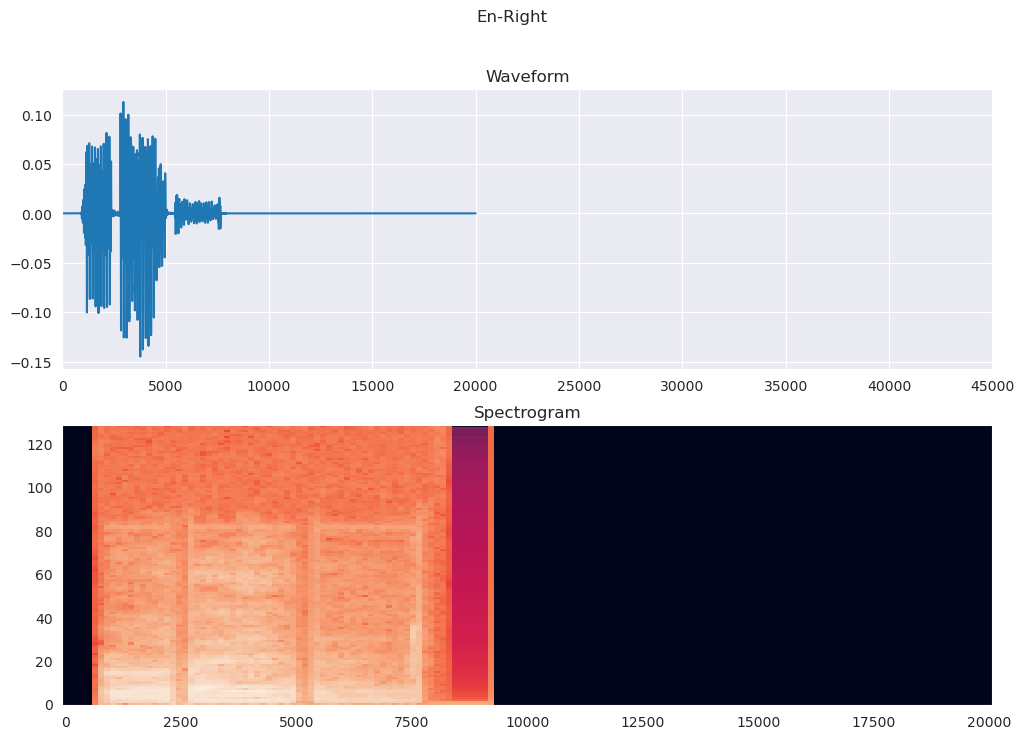

In [68]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 45000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [69]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model
train_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [70]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [71]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

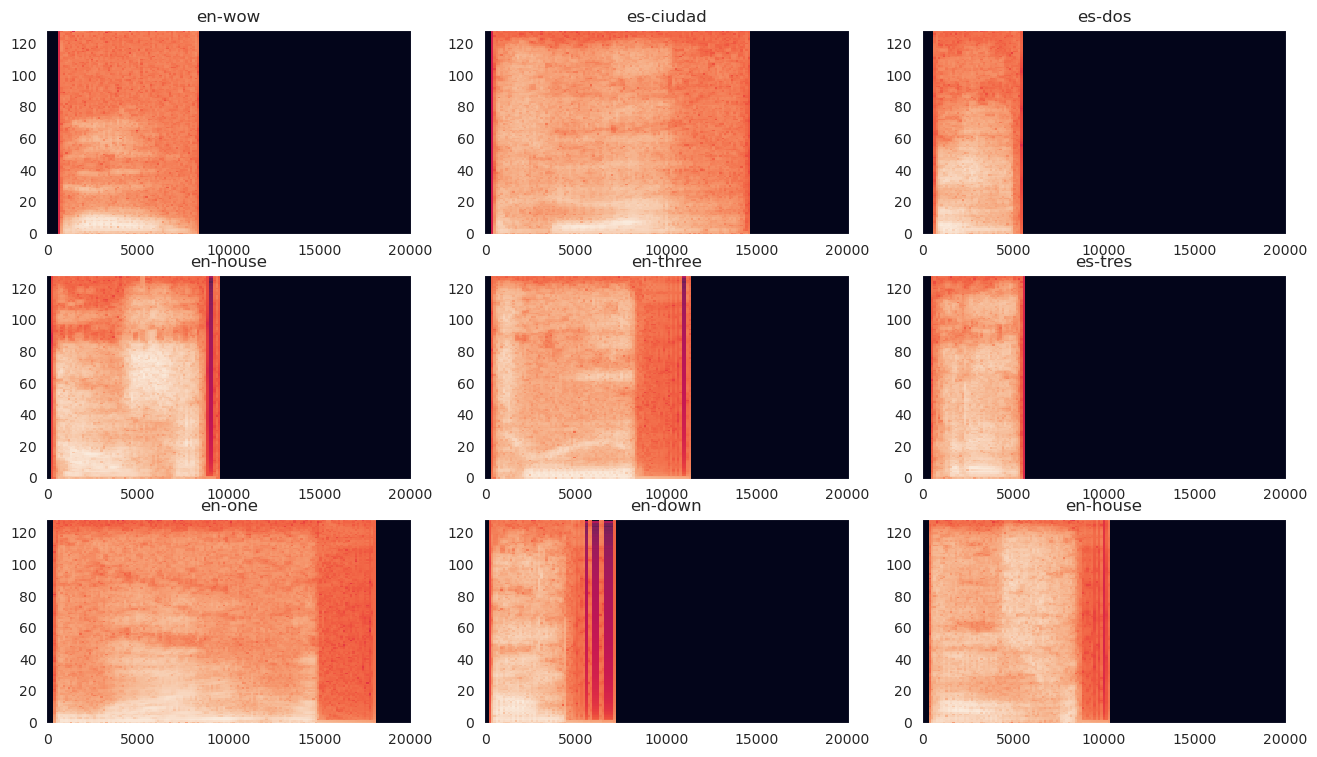

In [72]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(words[example_spect_labels[i].numpy()])

plt.show()

In [73]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [74]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(words)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (155, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [75]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [76]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


2022-10-20 06:40:55.388905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-10-20 06:40:56.233782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2022-10-20 06:40:56.973339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-20 06:40:56.981678: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0837e81c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-20 06:40:56.981689: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2022-10-20 06:40:56.986155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

1453/1453 [==============================] - 9s 4ms/step - loss: 1.7294 - accuracy: 0.5365 - val_loss: 0.9718 - val_accuracy: 0.7362
Epoch 2/20
1453/1453 [==============================] - 5s 3ms/step - loss: 1.1432 - accuracy: 0.6804 - val_loss: 0.7987 - val_accuracy: 0.7844
Epoch 3/20
1453/1453 [==============================] - 4s 3ms/step - loss: 0.9928 - accuracy: 0.7183 - val_loss: 0.6884 - val_accuracy: 0.8049
Epoch 4/20
1453/1453 [==============================] - 5s 3ms/step - loss: 0.9057 - accuracy: 0.7388 - val_loss: 0.6333 - val_accuracy: 0.8201
Epoch 5/20
1453/1453 [==============================] - 5s 3ms/step - loss: 0.8472 - accuracy: 0.7557 - val_loss: 0.6012 - val_accuracy: 0.8269
Epoch 6/20
1453/1453 [==============================] - 5s 3ms/step - loss: 0.8085 - accuracy: 0.7662 - val_loss: 0.5794 - val_accuracy: 0.8323
Epoch 7/20
1453/1453 [==============================] - 5s 3ms/step - loss: 0.7665 - accuracy: 0.7755 - val_loss: 0.5547 - val_accuracy: 0.8395
Epo

Text(0, 0.5, 'Accuracy [%]')

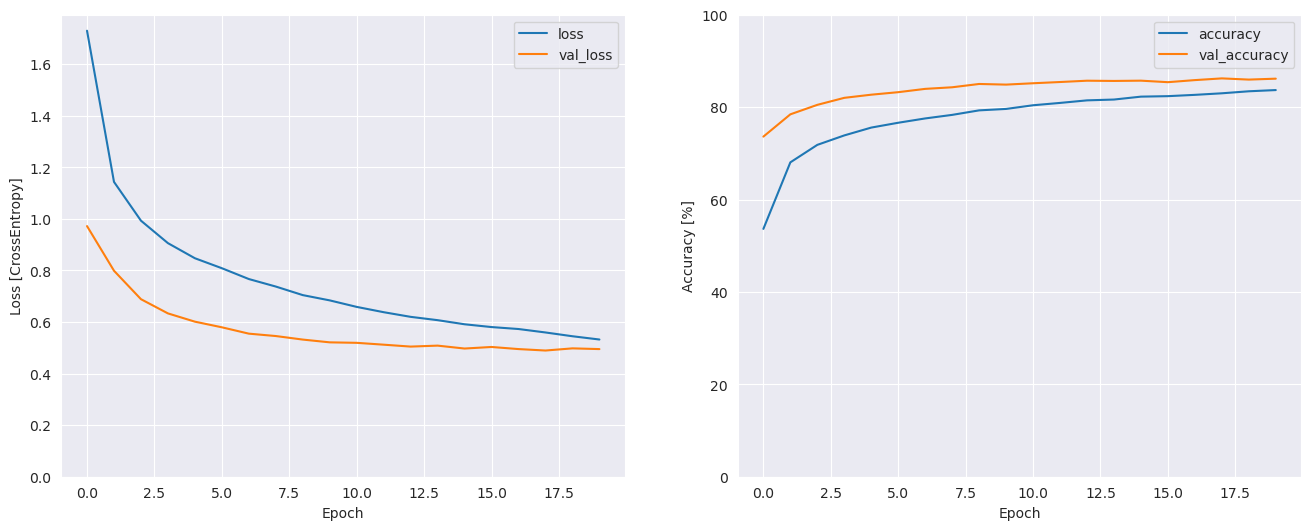

In [77]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [78]:
model.evaluate(test_spectrogram_ds, return_dict=True)

182/182 [==============================] - 1s 7ms/step - loss: 0.5127 - accuracy: 0.8546


{'loss': 0.5126875042915344, 'accuracy': 0.854567289352417}

In [79]:
y_pred = model.predict(test_spectrogram_ds)

182/182 [==============================] - 0s 1ms/step


In [80]:
y_pred = tf.argmax(y_pred, axis=1)

In [81]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

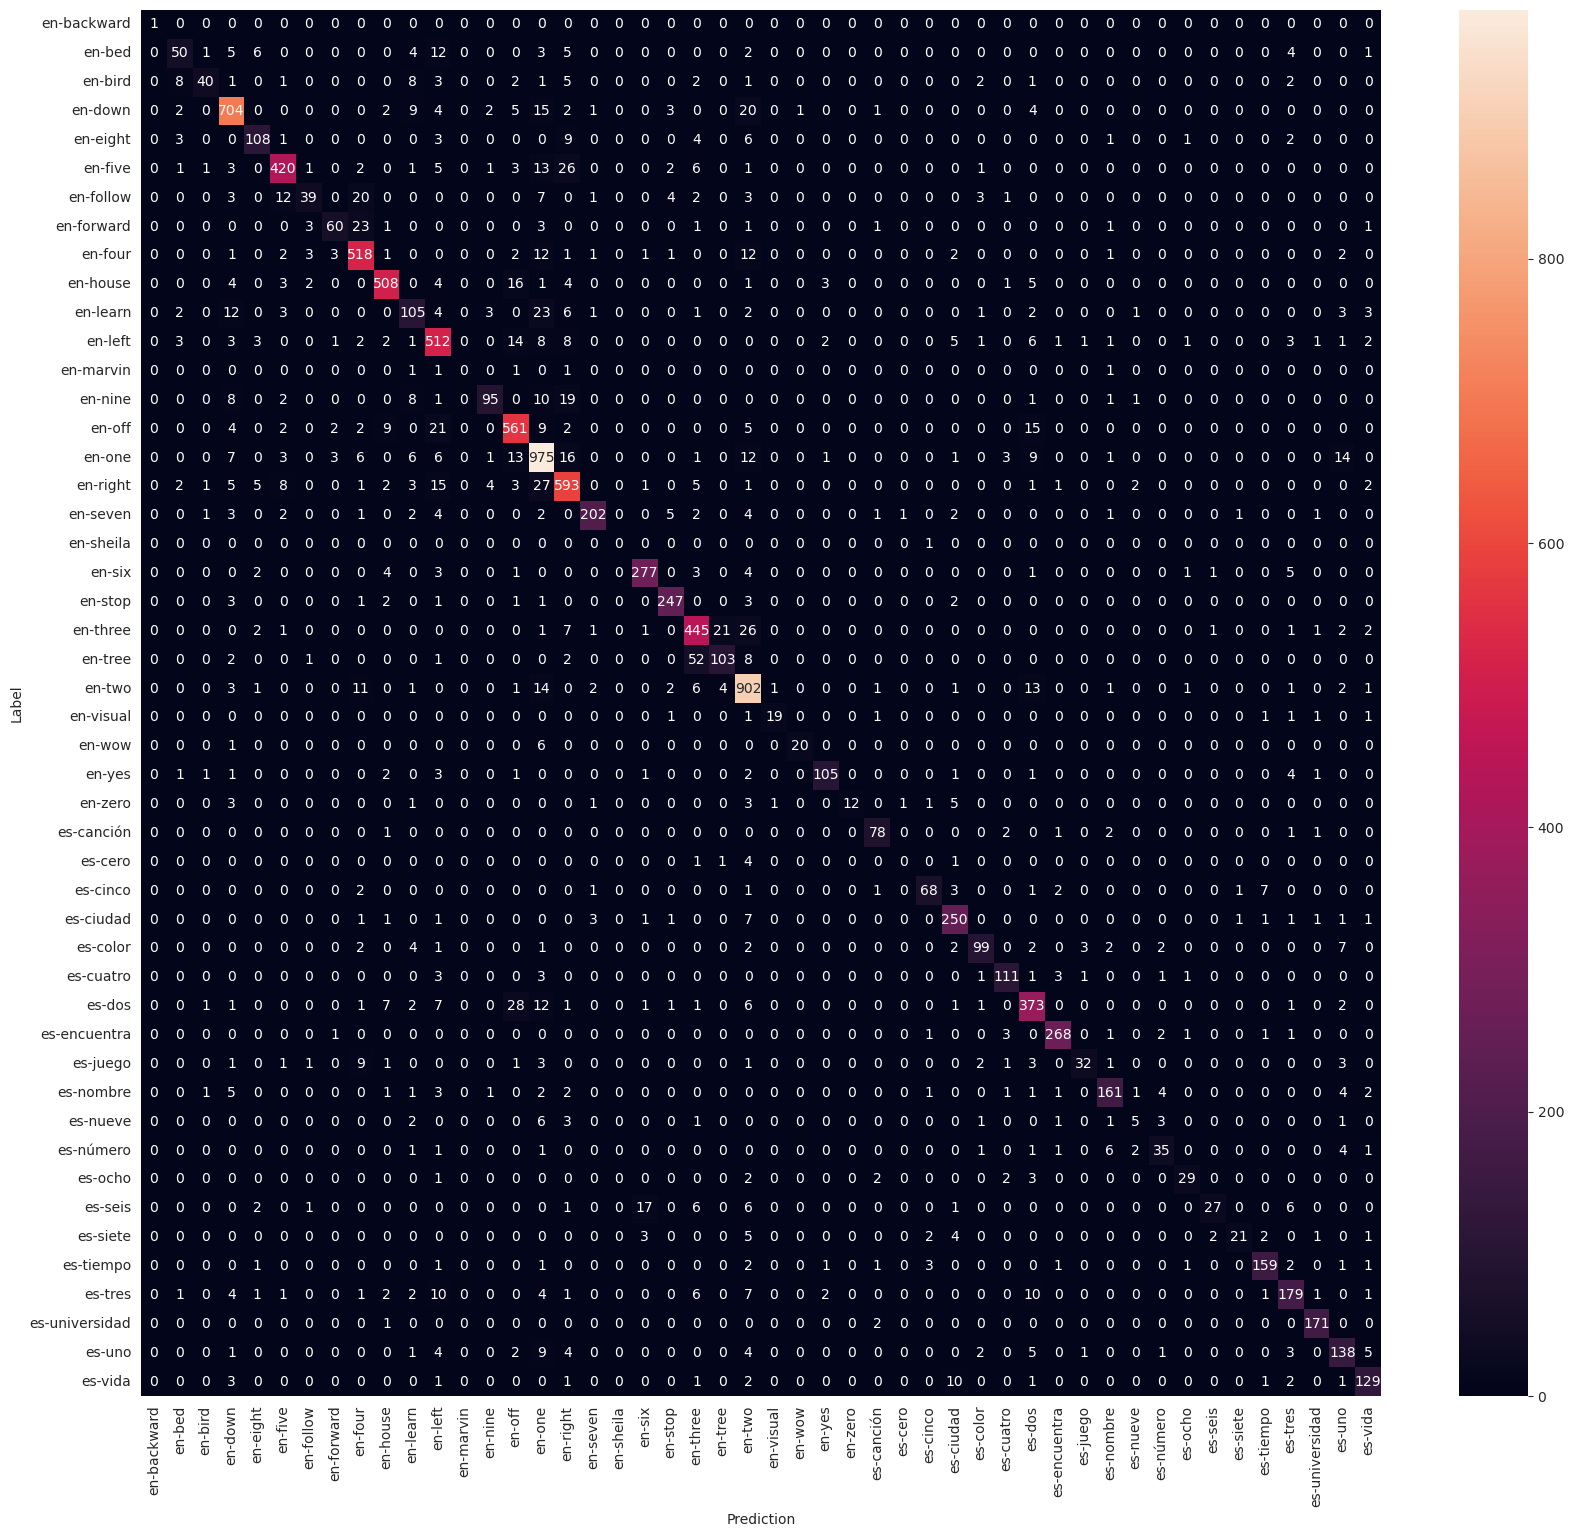

In [82]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx,
            xticklabels=words,
            yticklabels=words,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [83]:
x = 'data/inference_samples/wow_sample.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=45000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.figure(figsize=(60,10))
plt.bar(words, tf.nn.softmax(prediction[0]))
plt.title('Wow')
plt.show()


display.display(display.Audio(waveform, rate=45000))

ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 155, 129, 1), found shape=(1, 350, 129, 1)

In [ ]:
# Save model in "./saved"
model.save("saved_trmd")